import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import calendar
import itertools

pd.set_option('display.max_columns', 50)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

sns.set_theme(style='darkgrid')

from models import MLP, ConvNet, LSTM
from train_test import train, test, output_to_accu, output_to_loss
from helpers import RSI, pred_to_perf, perf_to_stat, performance_plot, \
                    turnover, annual_alpha_plot_grossnet, annual_alpha_plot, correlation, \
                    pred_to_daily_ret, price_to_perf

# Data

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [3]:
from data import get_price_data
from backtest import backtest_strat
from helpers import resume_backtest, performance_plot, annual_alpha_plot, price_to_perf, correlation

In [4]:
price, bench_price, df_X = get_price_data()
daily_returns = price.pct_change().shift(1)

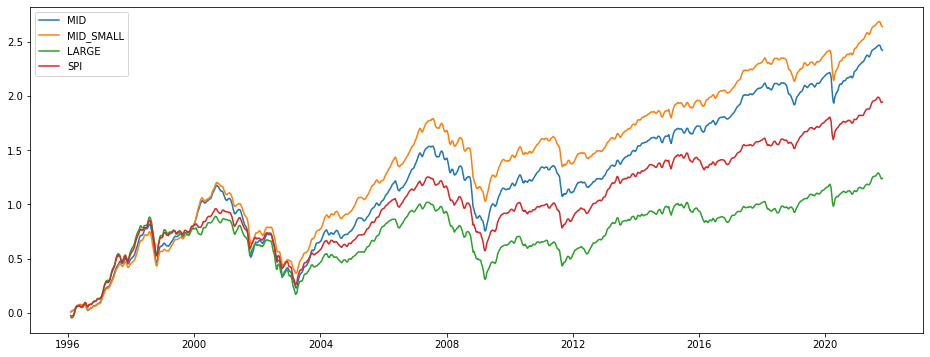

In [5]:
fig, ax = plt.subplots(figsize=(16,6))
data_plot = (pd.concat([price, bench_price.rename('SPI')], axis=1).pct_change() + 1).cumprod().rolling(20).mean()
sns.lineplot(data=np.log(data_plot), dashes=False)
plt.show()

In [6]:
models_list = ['MLP', 'ConvNet', 'LSTM']
# models_list = ['MLP', 'ConvNet']

df_pred_dict = {}
df_prob_dict = {}

threshold = 0.6
batch_size = 10
verbose = 0
training_window = 5
nb_epochs_first = 2
nb_epochs = 1
rebalance_freq = 'M'
input_period_days = 15
input_period_weeks = 8

if rebalance_freq == 'M':
    input_period = input_period_weeks
else:
    input_period = input_period_days

for i, model_name in enumerate(models_list):
    df_pred_dict[model_name], \
    df_prob_dict[model_name] = backtest_strat(df_input_all=df_X, price=price, rebalance_freq=rebalance_freq, 
                                              model_name=model_name, nb_epochs=nb_epochs, 
                                              nb_epochs_first=nb_epochs_first, input_period=input_period, 
                                              batch_size=batch_size, verbose=verbose, 
                                              training_window=training_window, threshold=threshold)

    if i == 0:
        df_prob_dict['Ensemble'] = df_prob_dict[model_name].copy()
    else:
        df_prob_dict['Ensemble'] += df_prob_dict[model_name]

df_prob_dict['Ensemble'] /= len(models_list)
df_pred_dict['Ensemble'] = pd.DataFrame().reindex_like(df_prob_dict['Ensemble']).fillna(0)
cols = df_pred_dict['Ensemble'].columns
for k in range(0, len(df_pred_dict['Ensemble'])):
    if k == 0:
        pred_index = df_prob_dict['Ensemble'].iloc[k].argmax()
        df_pred_dict['Ensemble'].iloc[k][cols[pred_index]] = 1
    else:
        out = df_prob_dict['Ensemble'].iloc[k].max()
        pred_index = df_prob_dict['Ensemble'].iloc[k].argmax()
        if out > threshold:
            df_pred_dict['Ensemble'].iloc[k][cols[pred_index]] = 1
        else:
            df_pred_dict['Ensemble'].iloc[k] = df_pred_dict['Ensemble'].iloc[k-1]

  0%|          | 0/40 [00:00<?, ?it/s]

Backtesting model MLP


  0%|          | 0/40 [00:00<?, ?it/s]

Backtesting model ConvNet


  0%|          | 0/40 [00:00<?, ?it/s]

Backtesting model LSTM


100%|██████████| 40/40 [00:10<00:00,  3.99it/s]


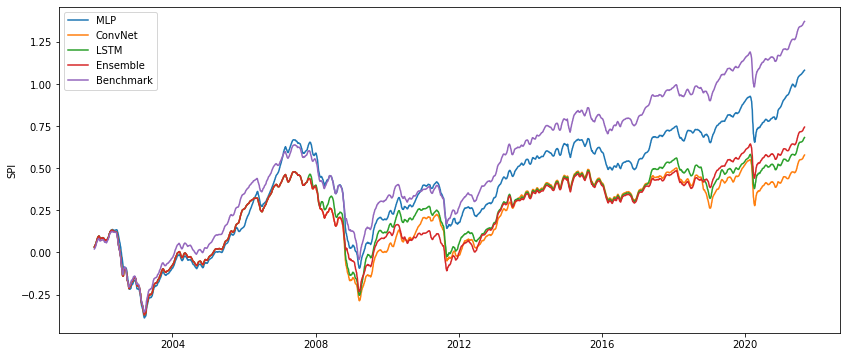

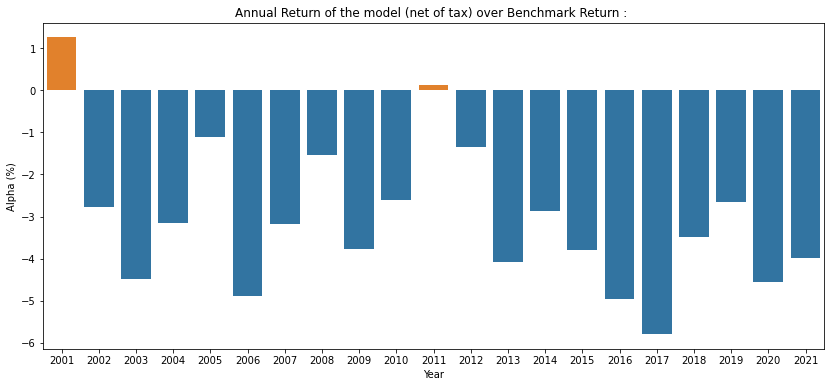

,Gross avg. annual return (%),Net avg. annual return (%),Avg. annual vol. (%),Avg Sharpe ratio,Max. Drawdown (%),Turnover
Benchmark SPI,8.18,8.18,17.12,0.48,44.52,0
MLP,7.64,7.51,16.28,0.46,46.45,23
ConvNet,4.94,4.88,17.09,0.29,46.65,9
LSTM,5.39,5.33,16.79,0.32,47.72,10
Ensemble,5.15,5.15,17.93,0.29,45.09,0


In [7]:
df_resume = resume_backtest(df_pred_dict, bench_price, price)
daily_returns = price.pct_change().shift(1)
perf_bench = price_to_perf(bench_price.loc[df_pred_dict['Ensemble'].index[0]:df_pred_dict['Ensemble'].index[-1]], log=False)
performance_plot(df_pred_dict, daily_returns, bench_price, log=True)
annual_alpha_plot(perf_bench, df_pred_dict['Ensemble'], daily_returns)
display(df_resume)

In [8]:
df = pd.DataFrame(index=models_list, columns=models_list)
for comb in itertools.product(models_list, repeat=2):
    model1 = comb[0]
    model2 = comb[1]
    df.loc[model1][model2] = correlation(df_pred_dict[model1], df_pred_dict[model2])
df = df.astype(float)
df.round(2)

,MLP,ConvNet,LSTM
MLP,1.0,0.70,0.60
ConvNet,0.7,1.00,0.78
LSTM,0.6,0.78,1.00


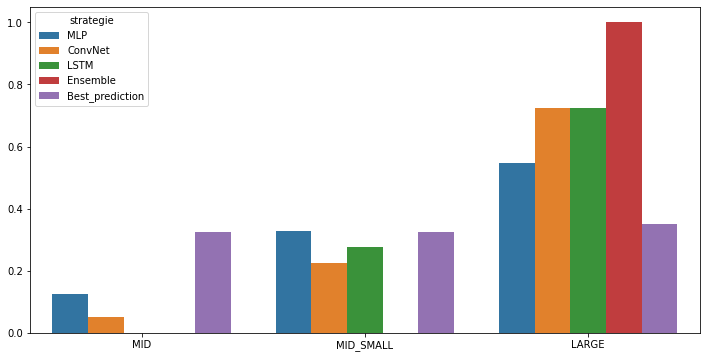

In [9]:
df_results = pd.DataFrame()

for model_name in df_pred_dict:
    L = len(df_pred_dict[model_name])
    df_results = pd.concat([df_results, (df_pred_dict[model_name].sum(axis=0) / L).rename(model_name)], axis=1)

returns = price.pct_change().shift(1).resample(rebalance_freq).agg(lambda x: (x + 1).prod() - 1)
best_pred = returns.rank(axis=1).replace({1: 0., 2: 0., 3: 1.}).shift(-1).loc[df_pred_dict[model_name].index[0]:df_pred_dict[model_name].index[-1]]

df_results = pd.concat([df_results, (best_pred.sum(axis=0) / L).rename('Best_prediction')], axis=1)
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='index', var_name='strategie', value_name='frequence')

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=df_results, x='index', y='frequence', hue='strategie')
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.show()